# Load stack_tup

In [1]:
%matplotlib inline
# imports
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy,imp 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii,fits
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from linetools.spectralline import AbsLine
import linetools.utils as ltu
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
from xastropy.xutils import fits as xxf
sys.path.append(os.path.abspath("../../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("../Bootstrap/py"))
import qpq9_boot as qpq9b
sys.path.append(os.path.abspath("./py"))
import qpq9_stacks as qpq9k

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999),
                               vsig_cut=400*u.km/u.s,plot_indiv=False)
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1002+0020' in dd['qpq']['NAME']: #CIV overlaps with BAL of background quasar
        idx_mask.append(ii) 
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

/Users/lwymarie/python/specdb/specdb/query_catalog.py:140: UserWarning: No sources found at your coordinate within tol=0.5 arcsec.  Returning None
  warnings.warn("No sources found at your coordinate within tol={:g}.  Returning None".format(tol))
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:295: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
4.16742968355 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=4046.04 Angstrom!
5.31851654482 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=4549.59 Angstrom!
7.94386588253 1 / Angstrom
Using spec-6197-56191-0089.fits.gz for BOSSJ0042+1350
S/N 7.94386588253 1 / Angstrom
5.99344013527 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ005718.90-000134.7.fits for BOSSJ0057-0001
S/N 5.99344013527 1 / Angstrom
13.1527026774 1 / Angstrom
Using spec-3735-55209-0693.fits.gz for BOSSJ0103-0002
S/N 13.1527026774 1 / Angstrom
7.58598984608 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ014917.46-002158.4.fits.gz for SDSSJ0149-0021
S/N 7.58598984608 1 / Angstrom
10.427618679 1 / Angstrom
Using spec-4236-55479-0340.fits.gz for BOSSJ0214-0052
S/N 10.427618679 1 / Angstrom
12.0499530386 1 / Angstrom
2.10096181157 1 / Angstrom
Using spec-6780-56605-0459.fits.gz for BOSSJ0

/Users/lwymarie/python/specdb/specdb/query_catalog.py:145: UserWarning: Found multiple sources in the catalog. Taking the closest one
  warnings.warn("Found multiple sources in the catalog. Taking the closest one")
/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__itruediv__(other)



Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ040954.21-041137.1_F.fits.gz for SDSSJ0409-0411
S/N 35.6192967728 1 / Angstrom
5.11061432957 1 / Angstrom
No spectrum found for BOSSJ0749+3702 and wvobs=4577.83 Angstrom!
11.0020897816 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ075259.14+401118.4.fits.gz for SDSSJ0752+4011
S/N 11.0020897816 1 / Angstrom
No spectrum found for APOJ0800+3542 and wvobs=4616.78 Angstrom!
5.53026538108 1 / Angstrom
Using spec-7328-56715-0428.fits.gz for BOSSJ0809+4539
S/N 5.53026538108 1 / Angstrom
12.6323172774 1 / Angstrom
Using spec-4463-55868-0778.fits.gz for BOSSJ0812+2620
S/N 12.6323172774 1 / Angstrom
16.5592364513 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ081833.97+123215.4.fits for BOSSJ0818+1232
S/N 16.5592364513 1 / Angstrom
7.70446349947 1 / Angstrom
Using spSpec-51868-0441-618.fit.gz for BOSSJ0826+4708
S/N 7.70446349947 1 / Angstrom
13.9947029413 1 / Angstrom
8.37304690816 1 / Angstrom
Usi

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:269: RuntimeWarning: invalid value encountered in greater
  gdsigval = np.where(self.data['sig'][kk].data > 0.)[0]
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:270: RuntimeWarning: invalid value encountered in less_equal
  badsigval = self.data['sig'][kk].data <= 0.
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:807: UserWarning: Ignoring NAN and inf in flux
  warnings.warn("Ignoring NAN and inf in flux")
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:879: RuntimeWarning: invalid value encountered in less_equal
  bad = np.where(self.sig.value <= 0.)[0]


In [3]:
print(np.sum(stck_mskN,0))
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if np.sum(stck_mskN[ii,:]) == 0:
        continue
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

[ 89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
  89.  89.  89.  89.  89.  89.  88.  88.  88.  88.  88.  89.  89.  89.  89.
  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.
  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  89.  88.  88.  88.  88.
  88.]


(1.9295158964119219, 189.13986652183442)

## Stack and Plot

### Mean

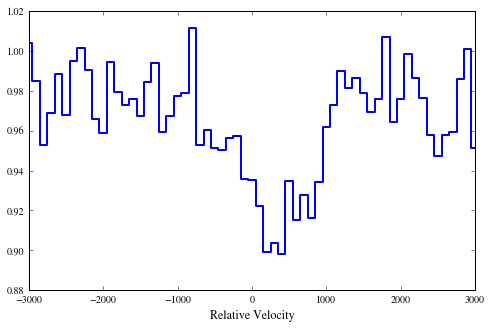

In [4]:
# Stack
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
# Plot
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Median

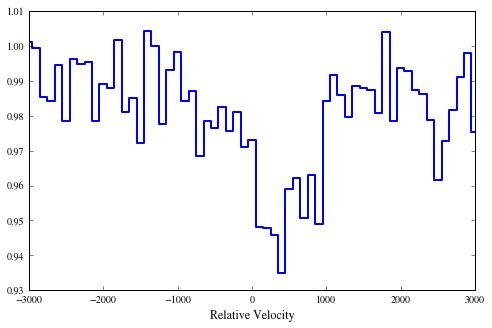

In [5]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

### Write 

In [6]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zIRMgII_1548_mean.fits'
relativistic_equiv = u.doppler_relativistic(1548.195*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zIRMgII_1548_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zIRMgII_1548_mean.fits
Wrote spectrum to Output/QPQ9_zIRMgII_1548_med.fits


## Bootstrap

In [7]:
#Mean
reload(qpq9b)
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/IRMgII_1548_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.584789, Median=0.567734, std=0.238134 for Ntrials=10000
Centroid: Mean = 90.8374, scatter=116.462
Dispersion and scatter of it:  312.112080224 108.14499572
max and min centroid:  362.144151402 -481.575250758
Wrote ../Bootstrap/Output/IRMgII_1548_mean.fits


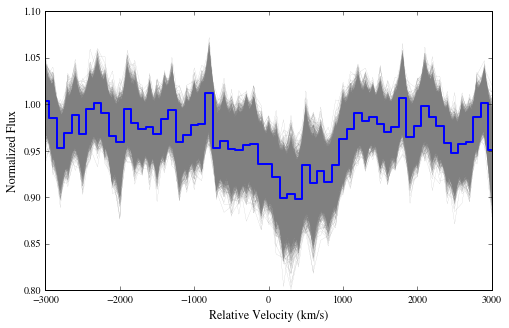

In [8]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1548_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

0.2139

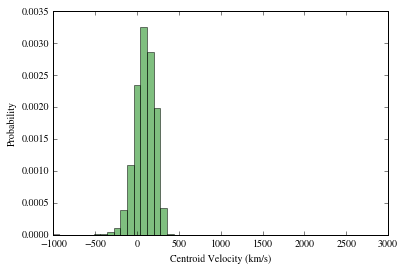

In [9]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen, 50, normed=1, facecolor='green', alpha=0.5, range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [10]:
#Median
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/IRMgII_1548_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.677419, Median=0.671816, std=0.248022 for Ntrials=10000
Centroid: Mean = 147.26, scatter=128.433
Dispersion and scatter of it:  303.233855307 242.098470079
max and min centroid:  1132.28988086 -509.758129109
Wrote ../Bootstrap/Output/IRMgII_1548_med.fits


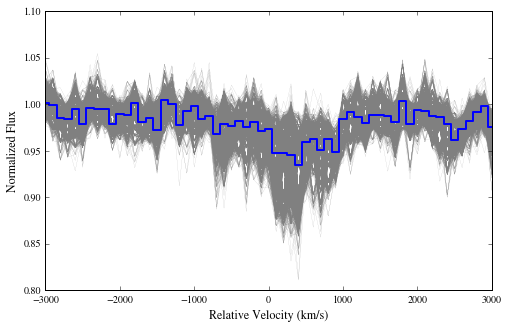

In [11]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/IRMgII_1548_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# [OIII] only

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
5.99344013527 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ005718.90-000134.7.fits for BOSSJ0057-0001
S/N 5.99344013527 1 / Angstrom


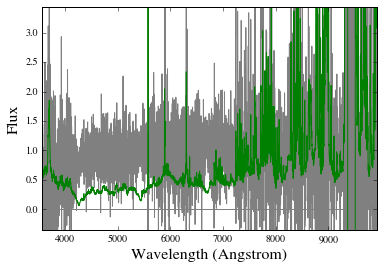

23.7541053843 1 / Angstrom
No continuum: /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ023946.44-010644.1_F.fits.gz
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ023946.45-010644.1.fits for BOSSJ0239-0106
S/N 23.7541053843 1 / Angstrom


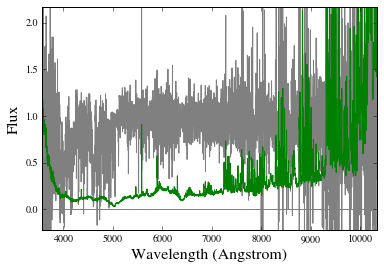

No spectrum found for APOJ0800+3542 and wvobs=4616.78 Angstrom!
14.0936784946 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ084159.26+392140.0.fits for BOSSJ0841+3921
S/N 14.0936784946 1 / Angstrom


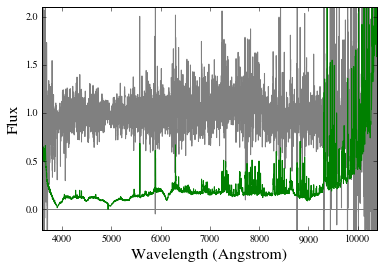

110.799035264 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ085357.49-001106.1_F.fits.gz for BOSSJ0853-0011
S/N 110.799035264 1 / Angstrom


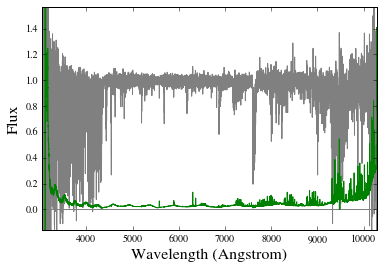

55.6813173064 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ091046.69+041448.4_F.fits.gz for APOJ0910+0414
S/N 55.6813173064 1 / Angstrom


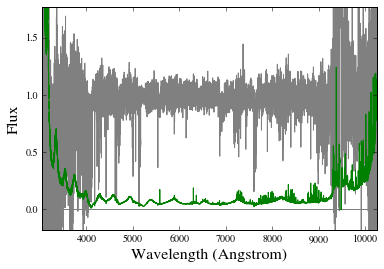

15.4871555291 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ091430.84+010927.5.fits for BOSSJ0914+0109
S/N 15.4871555291 1 / Angstrom


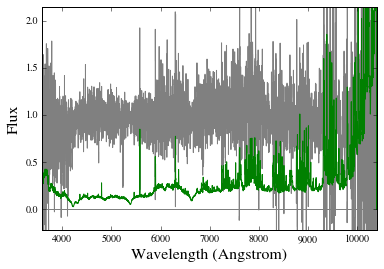

74.1064517969 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ093225.60+092500.2_F.fits.gz for APOJ0932+0925
S/N 74.1064517969 1 / Angstrom


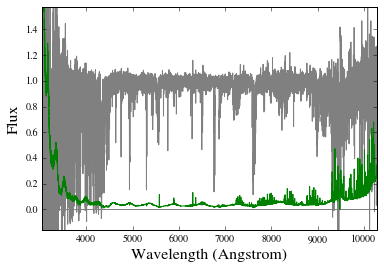

No spectrum found for APOJ0938+5317 and wvobs=4747.93 Angstrom!
16.7551504652 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_6_0/SDSSJ100627.10+480429.9.fits for BOSSJ1006+4804
S/N 16.7551504652 1 / Angstrom


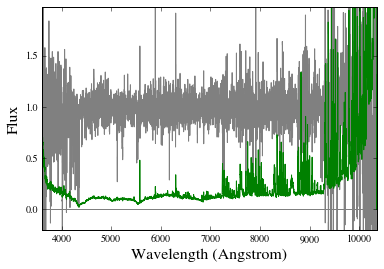

53.3526168379 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ103900.01+502652.8_F.fits.gz for BOSSJ1039+5026
S/N 53.3526168379 1 / Angstrom


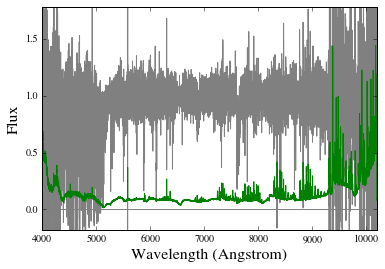

95.9890054286 1 / Angstrom
163.849797352 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ114436.66+095904.9_F.fits.gz for BOSSJ1144+0959
S/N 163.849797352 1 / Angstrom


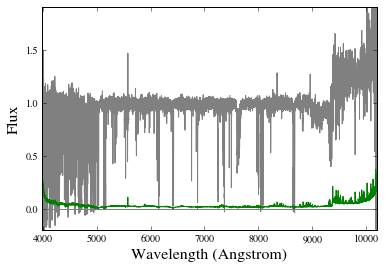

No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ120416.69+022111.0_b1200_F.fits.gz
No continuum: /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz
Using conti=1 for HIRES
129.809226794 1 / Angstrom
60.55960203 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/HIRES_redux//./SDSSJ120416.69+022111.0_f.fits.gz for BOSSJ1204+0221
S/N 129.809226794 1 / Angstrom


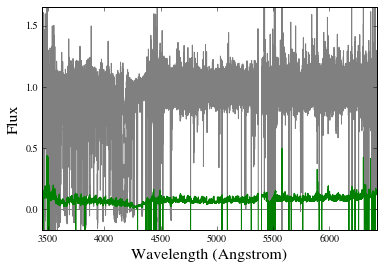

26.908602099 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/SDSS//./SDSSJ121558.80+571555.4.fits.gz for BOSSJ1215+5715
S/N 26.908602099 1 / Angstrom


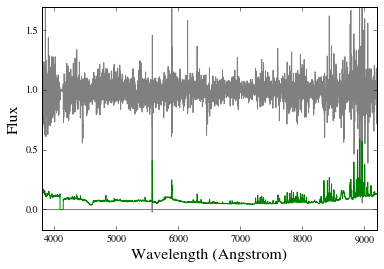

9.84155112217 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ123141.73+002913.9.fits for BOSSJ1231+0029
S/N 9.84155112217 1 / Angstrom


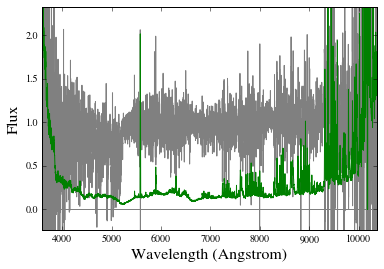

5.41014362307 1 / Angstrom
No spectrum found for BOSSJ1402+4701 and wvobs=4514.01 Angstrom!
53.8773711206 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ142004.12+022708.8_F.fits.gz for BOSSJ1420+0227
S/N 53.8773711206 1 / Angstrom


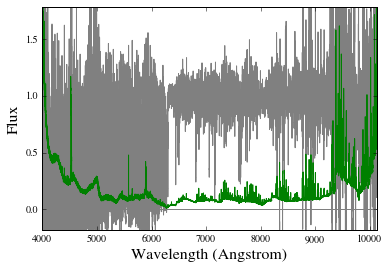

94.0746822297 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142054.92+160342.9_F.fits.gz for APOJ1420+1603
S/N 94.0746822297 1 / Angstrom


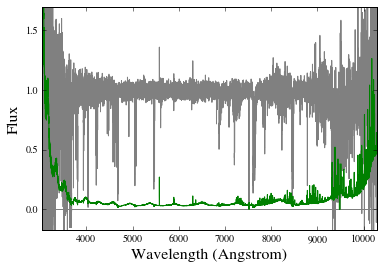

No continuum: /u/xavier/Dropbox//QSOPairs/data/GMOS_redux//./SDSSJ142758.74-012136.2_b1200_F.fits.gz
121.599217563 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ142758.74-012136.2_F.fits.gz for BOSSJ1427-0121
S/N 121.599217563 1 / Angstrom


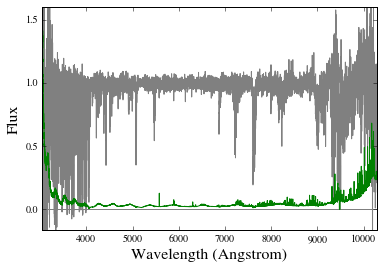

28.8212687508 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_4_45/SDSSJ143344.55+064111.9.fits for BOSSJ1433+0641
S/N 28.8212687508 1 / Angstrom


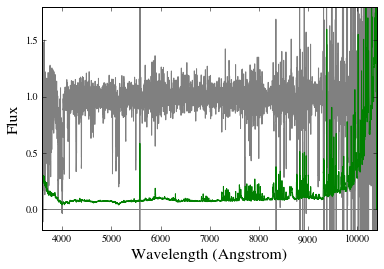

45.7814287976 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ155325.89+192137.7_F.fits.gz for APOJ1553+1921
S/N 45.7814287976 1 / Angstrom


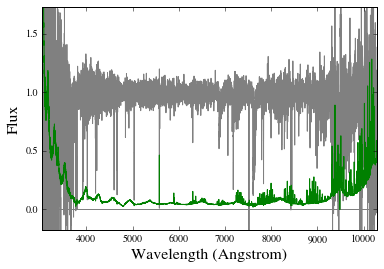

100.411969242 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/ESI_redux//./SDSSJ162737.25+460609.3_F.fits.gz for APOJ1627+4606
S/N 100.411969242 1 / Angstrom


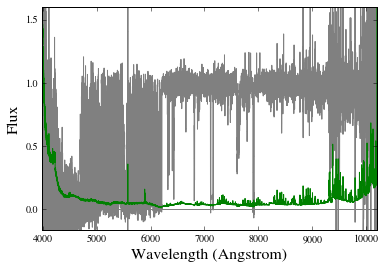

47.5768031362 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/MAGE_redux//./SDSSJ214620.98-075303.8_F.fits.gz for APOJ2146-0753
S/N 47.5768031362 1 / Angstrom


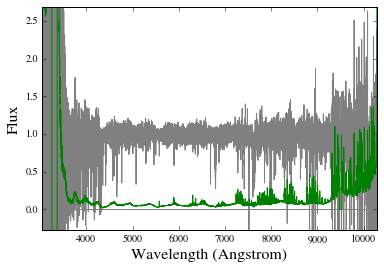

12.8011730822 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ220248.31+123656.3.fits for BOSSJ2202+1236
S/N 12.8011730822 1 / Angstrom


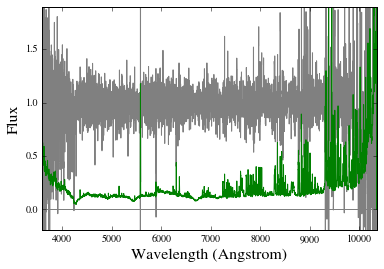

13.5319673561 1 / Angstrom
Using /u/xavier/Dropbox//QSOPairs/data/BOSS/v5_5_0/SDSSJ233845.45-000331.8.fits for BOSSJ2338-0003
S/N 13.5319673561 1 / Angstrom


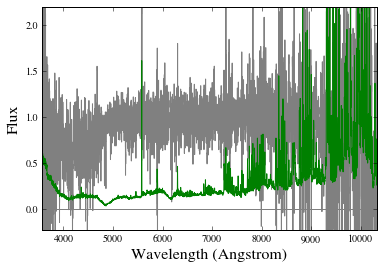

In [18]:
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=70*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1002+0020' in dd['qpq']['NAME']: #CIV overlaps with BAL of background quasar
        idx_mask.append(ii) 
for idx in idx_mask:
    stck_mskN[idx,:] = 0.

In [19]:
np.sum(stck_mskN,0)
sv_zfg = []
sv_Rperp = []
for ii,dd in enumerate(all_dict):
    if dd is None:
        continue
    if 'J1002+0020' in dd['qpq']['NAME']:
        idx_mask.append(ii) 
    sv_zfg.append(dd['qpq']['Z_FG'])
    sv_Rperp.append(dd['qpq']['R_PHYS'])
np.median(sv_zfg),np.median(sv_Rperp)

(2.2959557285185497, 120.92202374450571)

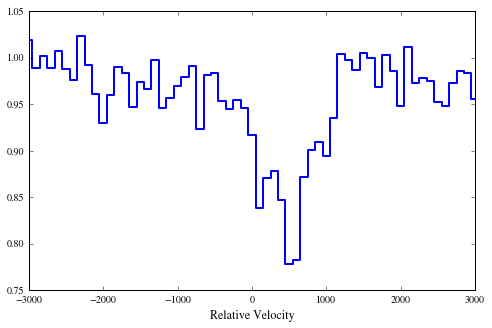

In [20]:
# Stack
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
# Plot
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

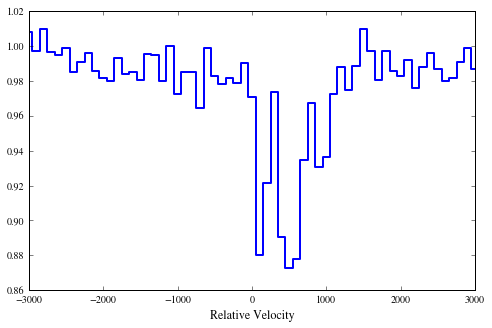

In [21]:
fin_velo, fin_flx_med, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [22]:
from linetools.spectra.xspectrum1d import XSpectrum1D
outfil = 'Output/QPQ9_zOIII_1548_mean.fits'
relativistic_equiv = u.doppler_relativistic(1548.195*u.AA)
fin_wave = fin_velo.to(u.AA,equivalencies=relativistic_equiv)
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx)))
xspec1d.write_to_fits(outfil,clobber=True)
outfil = 'Output/QPQ9_zOIII_1548_med.fits'
xspec1d = XSpectrum1D.from_tuple((fin_wave, u.Quantity(fin_flx_med)))
xspec1d.write_to_fits(outfil,clobber=True)

Wrote spectrum to Output/QPQ9_zOIII_1548_mean.fits
Wrote spectrum to Output/QPQ9_zOIII_1548_med.fits


## Bootstrap 

In [23]:
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/OIII_1548_mean.fits',stack_tup0=stack_tup)

Equivalent width skewness: Mean=0.707263, Median=0.707021, std=0.152559 for Ntrials=10000
Centroid: Mean = 193.636, scatter=84.5639
Dispersion and scatter of it:  240.151021285 53.5372789602
max and min centroid:  570.315935704 -569.886406752
Wrote ../Bootstrap/Output/OIII_1548_mean.fits


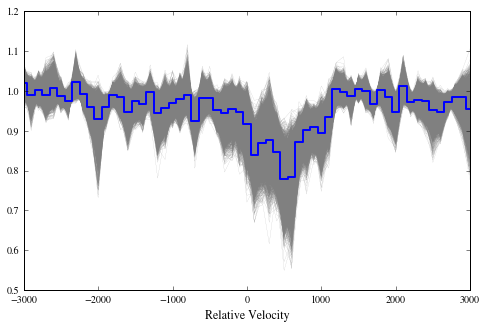

In [24]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1548_mean.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

0.0048

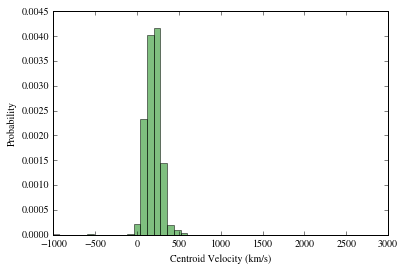

In [25]:
# Plot centroids
tau_cen = hdulist[3].data
n, bins, patches = plt.hist(tau_cen,50,normed=1,facecolor='green',alpha=0.5,range=(-1000,3000))
plt.xlabel('Centroid Velocity (km/s)')
plt.ylabel('Probability')
len(np.where(tau_cen < 0)[0])/len(tau_cen)

In [26]:
#Median
qpq9b.boot_trans(wrest=1548.195*u.AA,outfil='../Bootstrap/Output/OIII_1548_med.fits',stack_tup0=stack_tup,median=True)

Equivalent width skewness: Mean=0.776196, Median=0.79606, std=0.176269 for Ntrials=10000
Centroid: Mean = 246.095, scatter=123.228
Dispersion and scatter of it:  231.798085218 184.718220409
max and min centroid:  720.644410668 -699.548971979
Wrote ../Bootstrap/Output/OIII_1548_med.fits


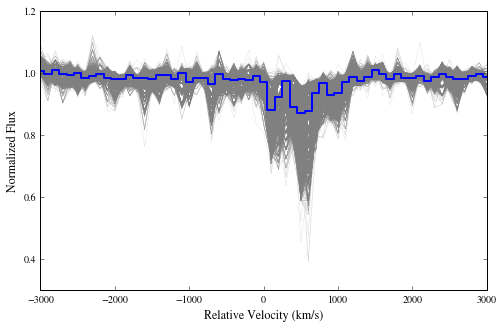

In [27]:
# plot 
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_med(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
hdulist = fits.open('../Bootstrap/Output/OIII_1548_med.fits')
boot_img = hdulist[1].data
for bb in np.arange(np.shape(boot_img)[0]):
    plt.plot(fin_velo,boot_img[bb,:],drawstyle='step-mid',linewidth=0.1,color='gray')
plt.plot(fin_velo, fin_flx_med, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity (km/s)', size=12.)
plt.ylabel('Normalized Flux', size=12.)
plt.show()

# Plot individual spectra

In [22]:
reload(qpq9k)
qpq9k.plt_qpq9(wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,stack_fg=True,zfg_mnx=(1.6,9999))

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
4.45497191017 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=4045.27 Angstrom!
4.2568704915 1 / Angstrom
No spectrum found for BOSSJ0008-0039 and wvobs=4548.73 Angstrom!
14.3274053574 1 / Angstrom
Using spSpec-51879-0419-251.fit.gz for BOSSJ0042+1350
S/N 14.3274053574 1 / Angstrom
20.4141807065 1 / Angstrom
Using spSpec-51783-0395-432.fit.gz for BOSSJ0057-0001
S/N 20.4141807065 1 / Angstrom
13.6853547591 1 / Angstrom
Using spSpec-52254-0693-120.fit.gz for BOSSJ0103-0002
S/N 13.6853547591 1 / Angstrom
No continuum: /u/xavier/Dropbox//QSOPairs/data/LRIS_redux//./SDSSJ011150.07+140141.4_b1200_F.fits.gz
No spectrum found for SDSSJ0111+1402 and wvobs=5395.68 Angstrom!
No spectrum found for SDSSJ0149-0021 and wvobs=4152.65 Angstrom!
17.8185081478 1 / Angstrom
Using spSpec-52209-0703-259.fit.gz for BOSSJ0214-0052
S/N 17.8185081478 1 / Angstrom
7.62136382534 1 / Angstrom
Using spSpec-52643-1072-096.fit.gz for BO

TypeError: 'NoneType' object has no attribute '__getitem__'

# Split in two bins of g_UV

## MgII redshift stack

In [ ]:
# Load QPQ9 data structure
enigma_path = imp.find_module('enigma')[1]
QPQ9 = xxf.bintab_to_table(enigma_path+'/data/qpq/qpq9_final.fits')
c_QPQ9 = SkyCoord(QPQ9['FG_RA']*u.deg,QPQ9['FG_DEC']*u.deg)
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']:
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']:
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median g_UV
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_gUV = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_gUV.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0])
med_gUV = np.median(sv_gUV)

In [ ]:
# Mask spectra of gUV below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV <= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of gUV above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    gUV = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['G_UV'][0]
    if gUV >= med_gUV:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of R_phys

## MgII redshift stack 

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys > med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

## [OIII] redshift stack

In [ ]:
# Find median R_phys
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_Rphys = []
for idict in all_dict:
    if idict == None:
        continue
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    sv_Rphys.append(QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0])
med_Rphys = np.median(sv_Rphys)

In [ ]:
# Mask spectra of R_phys below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys <= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

In [ ]:
# Mask spectra of R_phys above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    c_stacked = SkyCoord(idict['qpq']['FG_RA']*u.deg,idict['qpq']['FG_DEC']*u.deg)
    R_phys = QPQ9[np.where(c_stacked.separation(c_QPQ9) < 0.5*u.arcsec)[0]]['R_PHYS'][0]
    if R_phys >= med_Rphys:
        idx_mask.append(ii)
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

# Split in two bins of velocity separations 

## MgII redshift stack 

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,S2N_cut=3/u.AA,zfg_mnx=(1.6,9999),atmosphere_cut=True)
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

## [OIII] redshift stack

In [ ]:
# Find median velocity separation 
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1548.195*u.AA,vsig_cut=50*u.km/u.s,S2N_cut=5.5/u.AA,zfg_mnx=(1.6,9999))
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
sv_dv = []
for idict in all_dict:
    if idict == None:
        continue
    sv_dv.append(ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value)
print(sv_dv)
med_dv = np.median(sv_dv)

In [ ]:
# Mask spectra of velocity separation below median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv <= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))

In [ ]:
# Mask spectra of velocity separation above median 
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = []
sv_z = []
for ii,idict in enumerate(all_dict):
    if idict is None:
        continue
    if 'J1002+0020' in idict['qpq']['NAME']: 
        idx_mask.append(ii) 
    dv = ltu.v_from_z(idict['qpq']['BG_Z'],idict['qpq']['Z_FG']).value
    if dv >= med_dv:
        idx_mask.append(ii)
        sv_z.append(idict['qpq']['Z_FG'])
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps-mid',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()
print('median z_fg of this stack =',np.median(sv_z))